In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./measurements')
meas_dict = {}
for fname in os.listdir(meas_dir):
    with open(os.path.join(meas_dir, fname)) as file:
        meas = [[float(el) for el in row.rstrip().split('\t')]
                for row in file.readlines()]
        meas_name = os.fsdecode(fname).removesuffix('.txt')
        meas_dict[meas_name] = np.array(meas).T

In [3]:
# Constants and measured/given dimensions of the setup.
μ_0 = 1.256e-6
S, ΔS = 4e-2**2, 2*4e-2 * 0.5e-2
a, Δa = 10.9e-2, 0.5e-2
b, Δb = 13e-2, 1e-2
L, ΔL = 2*a + 2*b, 2*Δa + 2*Δb
d, Δd = 1.68e-3/18, 0.01e-3/18
N, n = 1000, 46

In [4]:
1e3*d, 1e6*Δd

(0.09333333333333334, 0.5555555555555556)

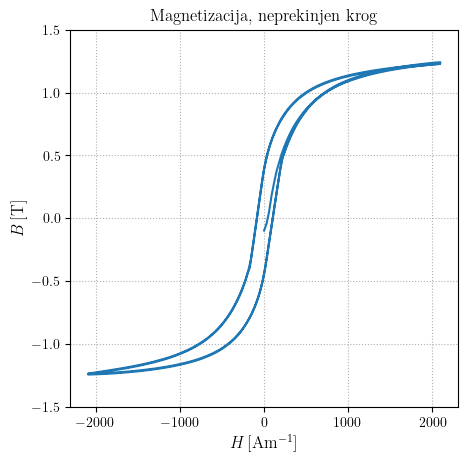

In [5]:
# Calculate H and B fields and make the hysteresis loop symmetrical.
# No need to do it for H as H_0 = 0 to a high enough accuracy.
t, I, U, F = meas_dict['transformer-loop']
H = N/L * I
B = 1/(S*n) * F
B -= 0.5 * (np.min(B) + np.max(B))

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Magnetisation curve.
ax.plot(H, B, color='tab:blue')
ax.set_title('Magnetizacija, neprekinjen krog')

# Labels and style.
ax.set_xlabel(r'$H\,[\mathrm{Am^{-1}}]$')
ax.set_ylabel(r'$B\,[\mathrm{T}]$')
ax.set_ylim(-1.5, 1.5)
ax.grid(linestyle=':')
fig.savefig('transformer-loop.pdf')

In [6]:
# Returns an intersection of a line ax + by + c = 0, given by a touple
# l=(a,b,c) and a line segment |AB| between points A and B. If no
# intersection, returns None.
def llseg_intersect(l, A, B):
    l_ = np.cross(np.append(A, 1), np.append(B, 1))
    x, y, α = np.cross(l, l_)
    I = np.array([x, y]) / α
    AB, AI = B - A, I - A
    if 0 < np.dot(AB, AI) <= np.dot(AB, AB):
        return I
    return None

# Returns the first intersection of a line ax + by + c = 0, given by a touple
# l=(a,b,c) and a curve of n points, given by an array of shape (n, 2).
def lcurve_intersect(l, x_y):
    for i in range(len(x_y) - 1):
        A, B = x_y[i:i+2]
        I = llseg_intersect(l, A, B)
        if I is not None:
            return I
    return None

In [12]:
np.array([[1, 2]]).shape

(1, 2)

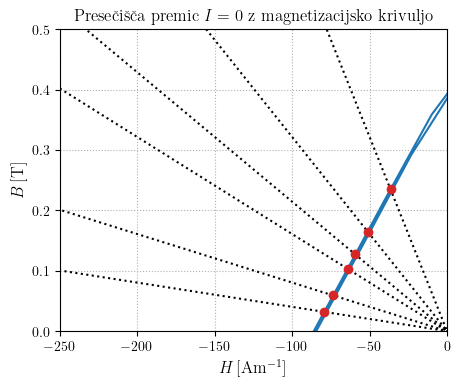

In [8]:
# Calculate intersection of I = 0 lines with the magnetisation curve.
k = -μ_0*L/d
H_B = np.stack((H, B), axis=1)
H_B_upper_left = H_B[(B > 0) * (H > 0)]
H_intersects, B_intersects = np.array(
    [lcurve_intersect((k, -i, 0), H_B[650:700]) for i in [1, 2, 3, 4, 8, 16]]).T

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

# H = 0 lines for slits of widths d, 2d, 3d, 4d, 8d and 16d.
H_slit = np.linspace(-180, 180)
ax.plot(H_slit, k*H_slit, color='black', linestyle=':', label=r'')
ax.plot(2*H_slit, k*H_slit, color='black', linestyle=':')
ax.plot(3*H_slit, k*H_slit, color='black', linestyle=':')
ax.plot(4*H_slit, k*H_slit, color='black', linestyle=':')
ax.plot(8*H_slit, k*H_slit, color='black', linestyle=':')
ax.plot(16*H_slit[7:-7], k*H_slit[7:-7], color='black', linestyle=':')

# Magnetisation curve and intersections.
ax.plot(H, B, color='tab:blue')
ax.scatter(H_intersects, B_intersects, color='tab:red', marker='o', zorder=3)

# Labels and style.
ax.set_title('Presečišča premic $I = 0$ z magnetizacijsko krivuljo')
ax.set_xlabel(r'$H\,[\mathrm{Am^{-1}}]$')
ax.set_ylabel(r'$B\,[\mathrm{T}]$')
ax.set_xlim(-250, 0)
ax.set_ylim(0, 0.5)
ax.grid(linestyle=':')
fig.savefig('intersections.pdf')

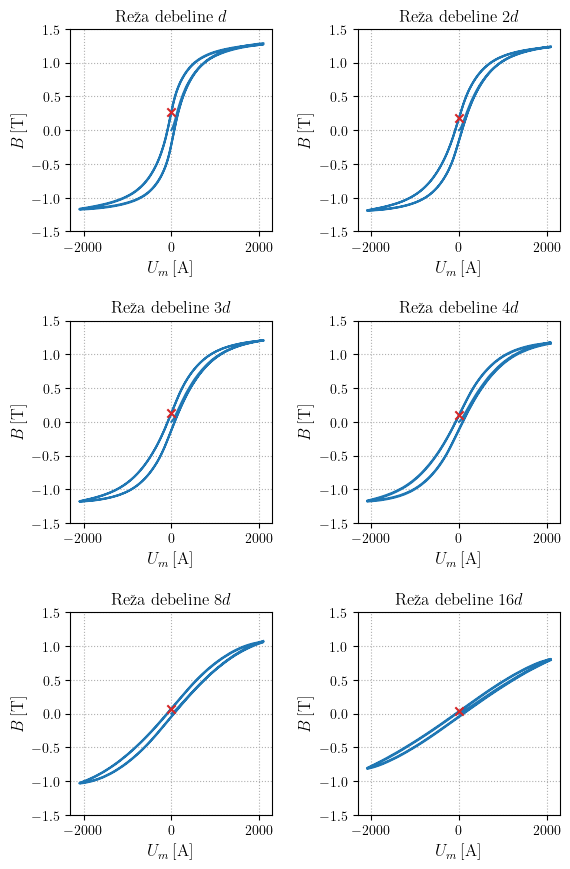

In [9]:
# Plots.
fig, axs = plt.subplots(3, 2, figsize=[6, 9])

slits = [
    meas_dict['slit-1-loop'],
    meas_dict['slit-2-loop'],
    meas_dict['slit-3-loop'],
    meas_dict['slit-4-loop'],
    meas_dict['slit-8-loop'],
    meas_dict['slit-16-loop']
]
titles = [f'Reža debeline ${s}d$' for s in ['', 2, 3, 4, 8, 16]]
real_B_at_I0 = []
for ax, meas, tit in zip(axs.flatten(), slits, titles):
    t, I, U, F = meas
    U_m = N * I
    B = 1/(S*n) * F
    U_m_B = np.stack((U_m, B), axis=1)
    U_m_B_upper = U_m_B[B > 0]
    U_m_intersect, B_intersect = lcurve_intersect((1, 0, 0), U_m_B_upper)
    real_B_at_I0.append(B_intersect)
    ax.scatter(U_m_intersect, B_intersect, color='tab:red', marker='x', zorder=3)
    ax.plot(H, B, color='tab:blue')
    ax.set_xlabel(r'$U_m\,[\mathrm{A}]$')
    ax.set_ylabel(r'$B\,[\mathrm{T}]$')
    ax.set_ylim(-1.5, 1.5)
    ax.grid(linestyle=':')
    ax.set_title(tit)
    
fig.tight_layout(pad=1.8)
fig.savefig('loops-side-by-side.pdf')

In [10]:
print(''.join([f'{i} & {1e3 * B:.1f} & {1e3 * real_B:.1f} & {1e3 * np.abs(real_B - B):.1f} & {np.abs(real_B/B - 1):.1} \\\\\n'
               for i, B, real_B in zip([1, 2, 3, 4, 8, 16], B_intersects, real_B_at_I0)]))

1 & 234.7 & 268.4 & 33.7 & 0.1 \\
2 & 164.8 & 173.0 & 8.2 & 0.05 \\
3 & 126.9 & 132.3 & 5.4 & 0.04 \\
4 & 103.2 & 99.5 & 3.7 & 0.04 \\
8 & 59.1 & 66.2 & 7.1 & 0.1 \\
16 & 31.9 & 32.1 & 0.2 & 0.007 \\



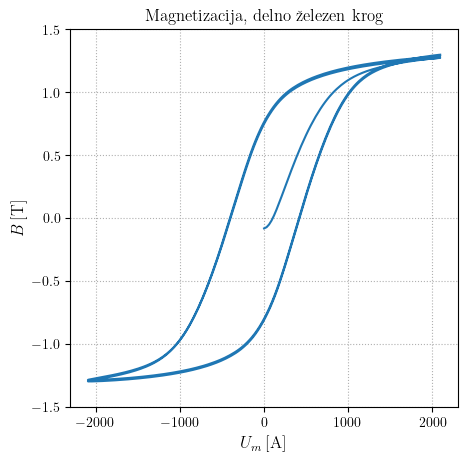

In [11]:
# Calculate H and B fields and make the hysteresis loop symmetrical.
# No need to do it for H as H_0 = 0 to a high enough accuracy.
t, I, U, F = meas_dict['iron-loop-repeat']
H = N/L * I
B = 1/(S*n) * F
B -= 0.5 * (np.min(B) + np.max(B))

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Magnetisation curve.
ax.plot(H, B, color='tab:blue')
ax.set_title('Magnetizacija, delno železen krog')

# Labels and style.
ax.set_xlabel(r'$U_m\,[\mathrm{A}]$')
ax.set_ylabel(r'$B\,[\mathrm{T}]$')
ax.set_ylim(-1.5, 1.5)
ax.grid(linestyle=':')
fig.savefig('iron-loop.pdf')